# Data pre-processing

Here we investigate the quality of the provided images. By randomly visualizing some samples, we noticed that some of them are completly black. So they don't bring any information, and worst case scenario, they impact the accuracy of the model after training. To quantify this, we compute the Mean Absolute Deviation of every images of the training set.


**Caution: Before executing this notebook, make sure to have generated at least the `mad_train.parquet` file. Simply execute:**

```bash
./run_mad.sh
```

In [52]:
import os
import polars as pl
from PIL import Image
from tqdm import tqdm

# root = '../data/val_images'
root = '../data/train_images'

# to_load = 'mad_val.parquet'
to_load = 'mad_train.parquet'

In [22]:
df = pl.read_parquet(to_load)
df = df.sort(by='mean_absolute_deviation')
df.head()

image_name,class_name,mean_absolute_deviation
str,str,f64
"""img_otmi8.jpeg""","""n01985128""",0.0
"""img_qe6fa.jpeg""","""n04347754""",0.0
"""img_me9zi.jpeg""","""n04152593""",0.0
"""img_uww8f.jpeg""","""n04152593""",0.0
"""img_vt9lo.jpeg""","""n04152593""",0.0


We validate here that images woth low or null MAD don't bring any information, hence leading to misclassifications in any case.

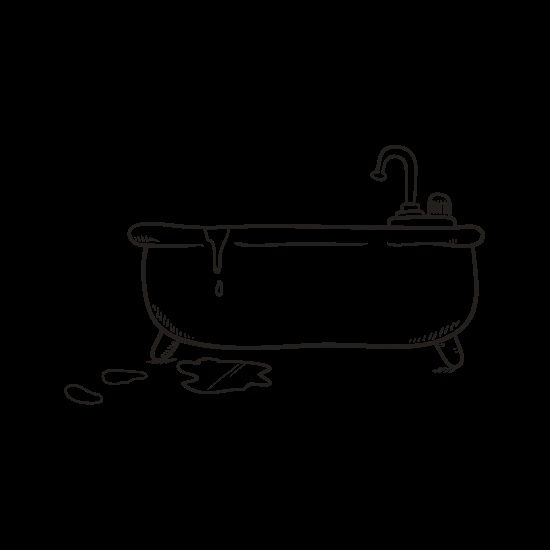

In [45]:
im = Image.open(os.path.join(root, df['class_name'][120], df['image_name'][120]))
im

To make sure we can actually drop them, we check that classes wouldn't be too underrepresented after the operation.  
As shown below, the operation would drop 5/40 images of one class, thus around 13%. We consider that this is acceptable.


_Note: The threshold at 2.0 is empirical_

In [50]:
zero_mad_counts = (
    df.filter(pl.col('mean_absolute_deviation') < 2.0).group_by('class_name').len().sort(by='len', descending=True)
)
print(f"{zero_mad_counts['len'].sum()} images with low variations")
zero_mad_counts.head()

120 images with low variations


class_name,len
str,u32
"""n03706229""",5
"""n04239074""",5
"""n04152593""",4
"""n03467068""",4
"""n03250847""",3


## Deleting useless samples

**Caution: This operation is not reversible**

In [54]:
filtered_df = df.filter(pl.col('mean_absolute_deviation') < 2.0)
for row in tqdm(filtered_df.iter_rows(named=True)):
    image_path = os.path.join(root, row['class_name'], row['image_name'])
    
    if os.path.exists(image_path):
        os.remove(image_path)
    else:
        print(f"File not found: {image_path}")

120it [00:00, 44423.34it/s]

File not found: ../data/train_images/n01985128/img_otmi8.jpeg
File not found: ../data/train_images/n04347754/img_qe6fa.jpeg
File not found: ../data/train_images/n04152593/img_me9zi.jpeg
File not found: ../data/train_images/n04152593/img_uww8f.jpeg
File not found: ../data/train_images/n04152593/img_vt9lo.jpeg
File not found: ../data/train_images/n04152593/img_eodgq.jpeg
File not found: ../data/train_images/n01560419/img_2tmsq.jpeg
File not found: ../data/train_images/n01560419/img_flqzw.jpeg
File not found: ../data/train_images/n07697537/img_q1lzk.jpeg
File not found: ../data/train_images/n04033901/img_28dad.jpeg
File not found: ../data/train_images/n02101556/img_1kzpo.jpeg
File not found: ../data/train_images/n02101556/img_0nhvx.jpeg
File not found: ../data/train_images/n02101556/img_72uh7.jpeg
File not found: ../data/train_images/n02276258/img_hwk9t.jpeg
File not found: ../data/train_images/n02276258/img_ajo72.jpeg
File not found: ../data/train_images/n02687172/img_zenww.jpeg
File not